In [188]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import random
from skimage import morphology, transform
import matplotlib.pyplot as plt
from keras.models import load_model
from keras import backend as K
import tensorflow as tf
import skimage
from skimage.io import imread, imread_collection
from skimage.segmentation import relabel_sequential
from skimage.morphology import label
import cv2
%matplotlib inline

In [192]:
seed=42
random.seed = seed
np.random.seed(seed)
BATCH_SIZE = 5
IMG_HEIGHT = IMG_WIDTH = 256
def mean_iou(y_true, y_pred):
    y_pred = tf.to_int32(y_pred > 0.5)
    score, up_opt = tf.metrics.mean_iou(y_true, y_pred, 2)
    K.get_session().run(tf.local_variables_initializer())
    with tf.control_dependencies([up_opt]):
        score = tf.identity(score)
    return score

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def normalize_image(in_rgb_img):
    grid_size = 8
    bgr = in_rgb_img[:, :, [2, 1, 0]]  # flip r and b
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(grid_size, grid_size))
    image = clahe.apply(lab[:, :, 0])
    if image.mean()>127:
        image = 255-image
    return image[...,np.newaxis]

In [282]:
data = np.load('data.npz')
X_train = data['X_train']
y_train = data['y_train']
model = load_model('model.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})
    
# data_gen_args = dict(rotation_range=90.,
#                          width_shift_range=0.1,
#                          height_shift_range=0.1,
#                          zoom_range=0.2,
#                          horizontal_flip=True,
#                          vertical_flip=True,
#                          fill_mode='wrap')
data_gen_args = dict()
image_datagen_train = ImageDataGenerator(**data_gen_args)
mask_datagen_train = ImageDataGenerator(**data_gen_args)
image_datagen_train.fit(y_train, augment=True, seed=seed)
mask_datagen_train.fit(y_train, augment=True, seed=seed)
image_generator_train = image_datagen_train.flow(
    X_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=seed)
mask_generator_train = mask_datagen_train.flow(
    y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=seed)

In [ ]:
def combine_generator(gen1, gen2):
    while True:
        yield(gen1.next(), gen2.next())
train_generator = combine_generator(image_generator_train, mask_generator_train)

In [ ]:
def add_contour_to_image(image, mask):
#     image = np.squeeze(image, axis=0)
#     mask = np.squeeze(mask, axis=0)
#     mask = np.squeeze(mask, axis=2)
    # print(image.shape)
    kernel = np.matrix([[0,0,1,0,0],
                            [0,1,1,1,0],
                            [1,1,1,1,1],
                            [0,1,1,1,0],
                            [0,0,1,0,0] ], dtype=np.bool)

#     contour = np.logical_xor(mask, morphology.binary_erosion(mask, kernel))
    contour = np.logical_xor(mask, morphology.binary_erosion(mask))

#     image[contour>0,0] = 255
#     image[contour>0,1] = 50
#     image[contour>0,2] = 0
    image[contour>0,0] = 255
    return image

In [126]:

fig = plt.figure(figsize=(20,15))
for image, mask in zip(images, masks) :
    
    print(image.shape)
    print(mask.shape)
    mask = np.squeeze(mask, axis=2)
    image = add_contour_to_image(image, mask)
    plt.subplot(331 + i)
    plt.imshow(image)
plt.show()

(256, 256, 3)
(256, 256)


AxisError: axis 2 is out of bounds for array of dimension 2

In [ ]:
X_test = data['X_test'][:6]
X_orig = data['X_orig'][:6]

sizes_test = data['sizes_test'][:6]



preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
preds_test_upsampled = []
for i in range(len(preds_test_t)):
    preds_test_upsampled.append(transform.resize(np.squeeze(preds_test_t[i]), (sizes_test[i][0], sizes_test[i][1]),
                                       mode='constant', preserve_range=True))

fig = plt.figure(figsize=(20,15))

for i in range(len(X_test)):
    print(preds_test_upsampled[i].shape)
    image = add_contour_to_image(X_orig[i], preds_test_upsampled[i])
    plt.subplot(331 + i)
    plt.imshow(image)
plt.show()

1/1 [==============================] - 0s 400ms/step


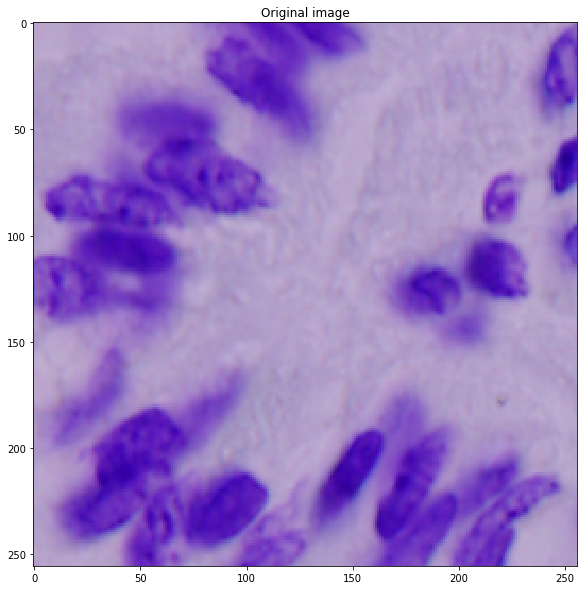

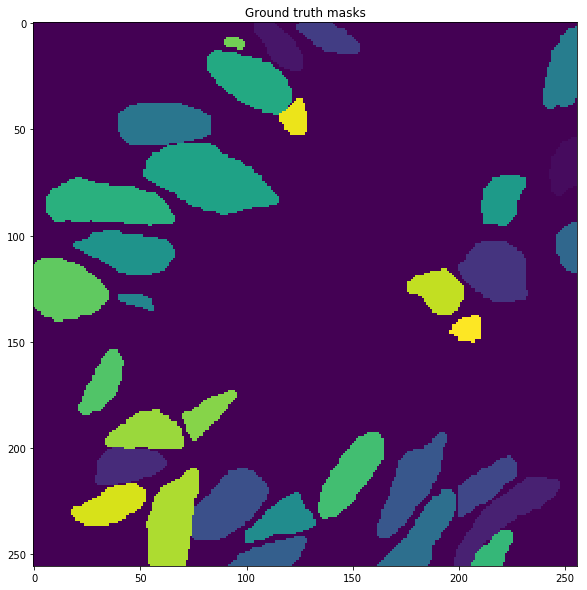

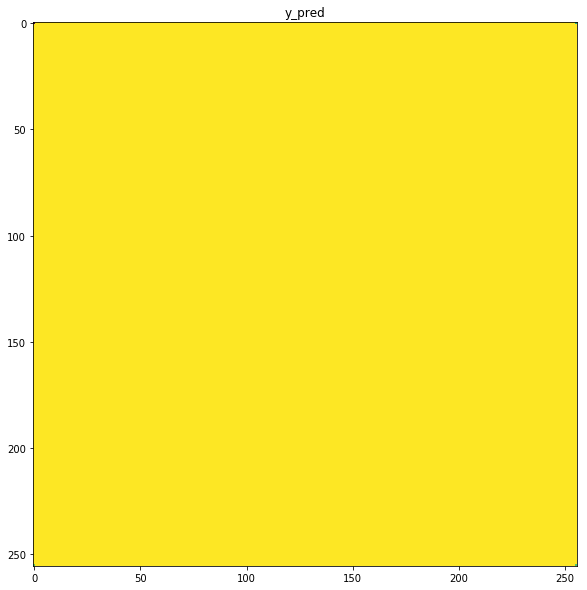

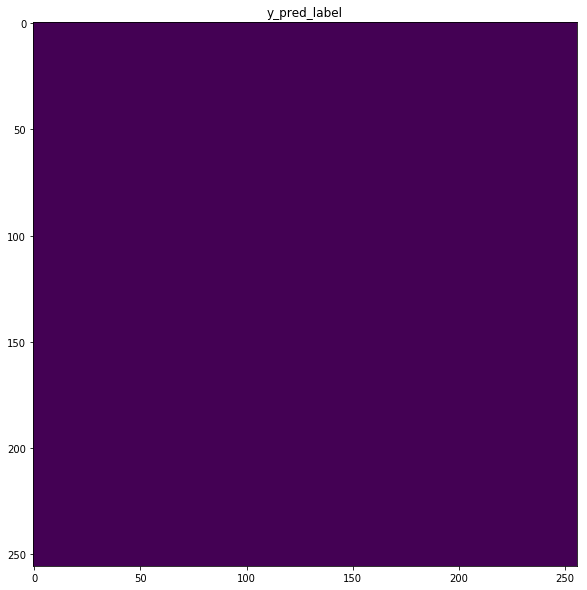

In [286]:
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

id = '7798ca1ddb3133563e290c36228bc8f8f3c9f224e096f442ef0653856662d121'
file = "../input/stage1_train/{}/images/{}.png".format(id,id)
masks = "../input/stage1_train/{}/masks/*.png".format(id)
image = imread(file)
image = transform.resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
image = image.astype(np.uint8)
# image = normalize_image(image)
# image = image / 255
masks = imread_collection(masks).concatenate()
masks = np.array([transform.resize(x, (IMG_HEIGHT, IMG_WIDTH), mode='constant') for x in masks])
height, width, _ = image.shape
num_masks = masks.shape[0]

# Make a ground truth label image (pixel value is index of object label)
labels = np.zeros((height, width), np.uint16)
for index in range(0, num_masks):
    labels[masks[index] > 0] = index + 1

img = image[:,:,:3]
img = img[np.newaxis,:,:]
y_pred = model.predict(img/255, verbose=1)
y_pred = np.squeeze(y_pred, axis=0)
y_pred = np.squeeze(y_pred, axis=2)
cutoff = 0.5
y_pred_label = label(y_pred > cutoff)
y_pred_label, _, inverse_map = skimage.segmentation.relabel_sequential(y_pred_label) # Relabel objects

fig = plt.figure(figsize=(10,10))
plt.imshow(np.squeeze(image))
plt.title("Original image")
fig = plt.figure(figsize=(10,10))
plt.imshow(labels)
plt.title("Ground truth masks")
fig = plt.figure(figsize=(10,10))
plt.imshow(y_pred)
plt.title("y_pred")
fig = plt.figure(figsize=(10,10))
plt.imshow(y_pred_label)
plt.title("y_pred_label")

# fig = plt.figure(figsize=(10,10))
# plt.hist(y_pred)
# plt.title("hist y_pred")
# image_ = y_pred > 0.5 #0.9999999
# image_ = np.squeeze(image_).astype(np.uint8)
# distance = ndi.distance_transform_edt(image_)
# local_maxi = peak_local_max(distance, indices=False, labels=image_, min_distance=5)#, footprint=np.ones((3, 3)))
# markers = ndi.label(local_maxi)[0]
# watershed_labels = watershed(-distance, markers, mask=image_)
# fig = plt.figure(figsize=(10,10))
# plt.imshow(distance)
# plt.title("distance")
# fig = plt.figure(figsize=(10,10))
# plt.imshow(watershed_labels)
# plt.title("labels watershed")
# # print(np.unique(watershed_labels))
# y_pred = watershed_labels
# # y_pred = y_pred_label

# # Compute number of objects
# true_objects = len(np.unique(labels))
# pred_objects = len(np.unique(y_pred))
# print("Number of true objects:", true_objects)
# print("Number of predicted objects:", pred_objects)

# # Compute intersection between all objects
# intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

# # Compute areas (needed for finding the union between all objects)
# area_true = np.histogram(labels, bins = true_objects)[0]
# area_pred = np.histogram(y_pred, bins = pred_objects)[0]
# area_true = np.expand_dims(area_true, -1)
# area_pred = np.expand_dims(area_pred, 0)

# # Compute union
# union = area_true + area_pred - intersection

# # Exclude background from the analysis
# intersection = intersection[1:,1:]
# union = union[1:,1:]
# union[union == 0] = 1e-9

# # Compute the intersection over union
# iou = intersection / union

# # Precision helper function
# def precision_at(threshold, iou):
#     matches = iou > threshold
#     true_positives = np.sum(matches, axis=1) == 1   # Correct objects
#     false_positives = np.sum(matches, axis=0) == 0  # Missed objects
#     false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
#     tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
#     return tp, fp, fn

# # Loop over IoU thresholds
# prec = []
# print("Thresh\tTP\tFP\tFN\tPrec.")
# for t in np.arange(0.5, 1.0, 0.05):
#     tp, fp, fn = precision_at(t, iou)
#     p = tp / (tp + fp + fn)
#     print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
#     prec.append(p)
# print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)


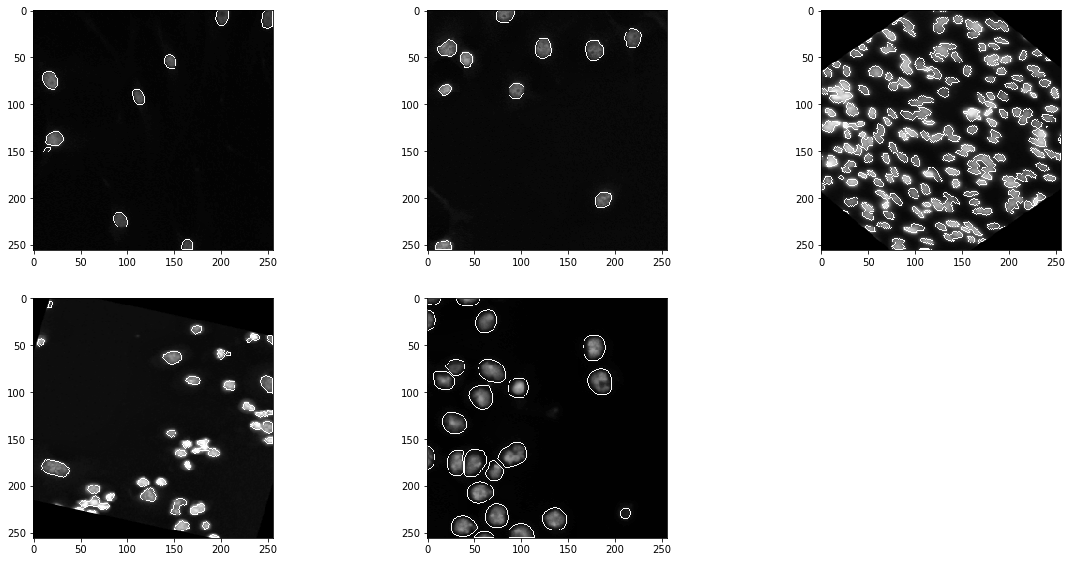

In [184]:
from imgaug import augmenters as iaa
import imgaug as ia
import cv2

def generator(seq, X, y, batch_size, hooks=None):
    while True:
        ix = np.random.randint(0, len(X), batch_size)
        X_aug = seq.augment_images(X[ix])
        y_aug = seq.augment_images(y[ix])#, hooks=hooks)
        yield X_aug, y_aug
def activator_masks(images, augmenter, parents, default):
    if augmenter.name in ["GaussianBlur", "Dropout"]:
        return False
    else:
        # default value for all other augmenters
        return default
    
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([
        iaa.Fliplr(0.2),
        iaa.Flipud(0.2),
#         iaa.GaussianBlur((0, 2.0), name="GaussianBlur"),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            rotate=(-90, 90),  # rotate by -45 to +45 degrees
            shear=(-20, 20),  # shear by -16 to +16 degrees
            cval=0,  # if mode is constant, use a cval between 0 and 255
            mode='constant'  # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ))
    ])
hooks_masks= ia.HooksImages(activator=activator_masks)
seq = seq.to_deterministic()
g = generator(seq, X_train, y_train.astype(np.float64), BATCH_SIZE, hooks=hooks_masks)
images, masks = next(g)
fig = plt.figure(figsize=(20,15))
i=0
for image, mask in zip(images, masks):
    print(mask.shape)
    mask = np.squeeze(mask, axis=2)
    image = add_contour_to_image(image, mask)
    plt.subplot(331 + i)
    plt.imshow(np.squeeze(image), cmap=plt.cm.gray)
#     plt.imshow(mask, cmap=plt.cm.gray)
    i += 1
plt.show()